# Finding a New Pet Store Location in St. Paul, MN

## Introduction / Business Problem

In 2019, US residents are estimated to spend [more than $75 billion](https://www.americanpetproducts.org/press_industrytrends.asp) for their pets. With more than 40\% of it being spent on food, pet store is a lucrative business to get into. 

Our friend, John Doe, wants to open a new pet store in St. Paul, MN area, and has asked me to help finding a location for it. Cost of doing business in a metropolis city like St. Paul can be stratospheric, so location needs to be analyzed carefully. The insight will provide a good understanding on the target market and reduce risk of opening a location in the wrong side of the city. 

## Target Audience

John Doe will be my target audience for this project. The objective is to locate a neighborhood to open his new pet store in the city of St. Paul, MN. We will ensure the neighborhood that I pick is the most optimum one. 

## Data and Methodology

### Zipcode data from [uszipcode](https://uszipcode.readthedocs.io/index.html#) Python package.  
It provides data for the **latitude and longitude** of all zipcode in the St. Paul, MN area along with the **median household income**.

In [1]:
import pandas as pd
import numpy as np
from uszipcode import SearchEngine
from geopy.geocoders import Nominatim 
import requests
import json 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium 

In [2]:
# using the uszipcode python package
searchzip = SearchEngine(simple_zipcode=False) # set simple_zipcode=False to use rich info database

In [3]:
# get the zip code from the surrounding St. Paul, MN area:
res = searchzip.by_city_and_state("Saint Paul", "MN", returns=40)

Let's create a dataframe containing all the zipcodes for St. Paul, MN area:

In [4]:
zipStPaul = pd.DataFrame(columns = ['zipcode','med_income','latitude','longitude'])

In [5]:
for data in res:
    zipcode = data.zipcode
    medincome = data.median_household_income
    latit = data.lat
    long = data.lng

    zipStPaul = zipStPaul.append({'zipcode': zipcode,
                                 'med_income': medincome,
                                 'latitude': latit,
                                 'longitude': long},ignore_index=True)

In [6]:
zipStPaul.head()

,zipcode,med_income,latitude,longitude
0,55101,40300,44.95,-93.09
1,55102,46255,44.93,-93.12
2,55103,28899,44.97,-93.13
3,55104,44629,44.96,-93.17
4,55105,76472,44.93,-93.16


In [7]:
zipStPaul.shape

(30, 4)

There are **thirty zip code** data that can be used for the FourSquare Places API.  
We will use _folium_ Python package to visualize the data:

First, we use geopy library to get the latitude and longitude values of St Paul, MN.

In [8]:
address = 'Saint Paul, MN'

geolocator = Nominatim(user_agent="spaul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of St Paul, MN are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of St Paul, MN are 44.9504037, -93.1015026.


In [9]:
# create map of St. Paul using latitude and longitude values
map_stPaul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode, medincome in zip(zipStPaul['latitude'], zipStPaul['longitude'], zipStPaul['zipcode'],zipStPaul['med_income']):
    label = '{}, {}'.format(zipcode, medincome)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stPaul)  
    
map_stPaul

#### Removing zip codes that are far awar from St. Paul area

I am going to remove zip codes that are far away from the St. Paul area:  
``55109``, ``55110``, ``55111``, ``55112``, ``55115``, ``55118``, ``55120``, ``55121``, ``55122``, ``55123``, ``55124``, ``55125``, ``55126``,``55127``,``55128``, ``55129``

In [10]:
dropziplist = ['55109','55110','55111','55112', 
               '55115', '55118', '55120', '55121', 
               '55122', '55123', '55124', '55125', 
               '55126','55127','55128', '55129']

zipStPaul = zipStPaul[~zipStPaul['zipcode'].isin(dropziplist)]

In [96]:
# saving the dataframe for presentation
zipStPaul.to_csv('zipStPaul.csv',index=False)

## FourSquare data from FourSquare [Places API](https://developer.foursquare.com/docs/api). 

I will utilize the explore function to get venue recommendations and zone in on the pet related categories (e.g. pet store, dog park, dog friendly restaurants) 

In [11]:
# get the ID and secret from the obfuscated file 
CLIENT_ID = pd.read_csv('../../Coursera_Capstone/FSclientID.txt',header=None)[0][0] # your Foursquare ID
CLIENT_SECRET = pd.read_csv('../../Coursera_Capstone/FSclientSecret.txt',header=None)[0][0] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [20]:
# modified from previous work:
def getNearbyVenues(zipcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results2 = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            results['response']['headerLocation'], 
            zipcode,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('postalCode',0),
            v['venue']['categories'][0]['name']) for v in results2])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Zipcode',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Zipcode',
                             'Venue Category']
    
    return(nearby_venues)

In [13]:
LIMIT = 100

In [22]:
stpaul_venues = getNearbyVenues(zipcode=zipStPaul['zipcode'],latitudes=zipStPaul['latitude'],
                               longitudes=zipStPaul['longitude'],
                               radius=4000)

In [23]:
stpaul_venues.head()

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55101,44.95,-93.09,Barrel Theory Beer Company,44.951021,-93.088258,55101,Brewery
1,Saint Paul,55101,44.95,-93.09,Mears Park,44.949371,-93.087920,55101,Park
2,Saint Paul,55101,44.95,-93.09,The Buttered Tin,44.950857,-93.088679,55101,Bakery
3,Saint Paul,55101,44.95,-93.09,CHS Field,44.950619,-93.084789,55101,Baseball Stadium
4,Saint Paul,55101,44.95,-93.09,St. Paul Farmers' Market,44.949620,-93.085131,55101,Farmers Market


In [24]:
stpaul_venues.shape

(1400, 9)

#### Cleaning up the `petstpaul_venues` data

I clean up the stpaul_venues data through the following methods:  
- Based on the `Venue` column, separate the unique and duplicated values into two
- In unique dataframe, fill in the `Venue Zipcode` column with the `Zipcode` column 
- In duplicated dataframe, separate them into zero `Venue Zipcode` and non-zero `Venue Zipcode` dataframe:
    - for non-zero `Venue Zipcode` dataframe, only keep the values where `Venue Zipcode` and `Zipcode` column matches
    - for zero `Venue Zipcode` dataframe, search manually and fill in the missing zipcode value

##### Separate the unique and duplicated values into two:

In [25]:
unique_stpaul_venues = stpaul_venues[~stpaul_venues.duplicated(subset='Venue',keep=False)]
duplicated_stpaul_venues = stpaul_venues[stpaul_venues.duplicated(subset='Venue',keep=False)]

##### In unique dataframe, fill in the `Venue Zipcode` column with the `Zipcode` column 

In [26]:
unique_stpaul_venues = unique_stpaul_venues.reset_index(drop=True)
for i in range(len(unique_stpaul_venues)):
    if unique_stpaul_venues.loc[i,'Venue Zipcode'] == 0:
        unique_stpaul_venues.loc[i,'Venue Zipcode'] = unique_stpaul_venues.loc[i,'Zipcode']

##### In duplicated dataframe, separate them into zero `Venue Zipcode` and non-zero `Venue Zipcode` dataframe:

In [27]:
duplicated_stpaul_venues = duplicated_stpaul_venues.sort_values(by='Venue')
zero_duplicated_stpaul_venues = duplicated_stpaul_venues[duplicated_stpaul_venues['Venue Zipcode']==0]
nonzero_duplicated_stpaul_venues = duplicated_stpaul_venues[~(duplicated_stpaul_venues['Venue Zipcode']==0)]

##### for non-zero `Venue Zipcode` dataframe, only keep the values where `Venue Zipcode` and `Zipcode` column matches

In [28]:
nonzero_duplicated_stpaul_venues = nonzero_duplicated_stpaul_venues.reset_index(drop=True)
nonzero_duplicated_stpaul_venues = nonzero_duplicated_stpaul_venues[
    nonzero_duplicated_stpaul_venues['Zipcode']==nonzero_duplicated_stpaul_venues['Venue Zipcode']]

##### for zero `Venue Zipcode` dataframe, search manually and fill in the missing zipcode value

In [29]:
zero_duplicated_stpaul_venues = zero_duplicated_stpaul_venues.reset_index(drop=True)
zero_duplicated_stpaul_venues.shape

(23, 9)

In [30]:
zero_duplicated_stpaul_venues.loc[0:10]

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Falcon Heights,55108,44.98,-93.18,Machinery Hill - Minnesota State Fair,44.985519,-93.169700,0,Electronics Store
1,Saint Paul,55114,44.97,-93.20,Machinery Hill - Minnesota State Fair,44.985519,-93.169700,0,Electronics Store
2,Roseville,55113,45.01,-93.16,Machinery Hill - Minnesota State Fair,44.985519,-93.169700,0,Electronics Store
3,Falcon Heights,55108,44.98,-93.18,Mighty Midway,44.980074,-93.175349,0,Theme Park Ride / Attraction
4,Saint Paul,55114,44.97,-93.20,Mighty Midway,44.980074,-93.175349,0,Theme Park Ride / Attraction
5,Roseville,55113,45.01,-93.16,Mighty Midway,44.980074,-93.175349,0,Theme Park Ride / Attraction
6,Saint Paul,55104,44.96,-93.17,Mighty Midway,44.980074,-93.175349,0,Theme Park Ride / Attraction
7,Saint Paul,55106,44.94,-93.05,Real Meal Delicatessen,44.947036,-93.090568,0,American Restaurant
8,Saint Paul,55107,44.93,-93.09,Real Meal Delicatessen,44.947036,-93.090568,0,American Restaurant
9,Saint Paul,55101,44.95,-93.09,Real Meal Delicatessen,44.947036,-93.090568,0,American Restaurant


In [31]:
# machinery hills
zero_duplicated_stpaul_venues.at[0,'Venue Zipcode'] = '55108'
# mighty midway
zero_duplicated_stpaul_venues.at[5, 'Venue Zipcode'] = '55113'
# real meal deli
zero_duplicated_stpaul_venues.at[9, 'Venue Zipcode'] = '55101'
# redbox
zero_duplicated_stpaul_venues.at[11, 'Venue Zipcode'] = '55117'
# redbox
zero_duplicated_stpaul_venues.at[12, 'Venue Zipcode'] = '55119'
# redbox
zero_duplicated_stpaul_venues.at[13, 'Venue Zipcode'] = '55117'
# subtext books
zero_duplicated_stpaul_venues.at[16, 'Venue Zipcode'] = '55102'
# subtext books
zero_duplicated_stpaul_venues.at[16, 'Zipcode'] = '55102'
# sweet martha cookie's
zero_duplicated_stpaul_venues.at[20, 'Venue Zipcode'] = '55113'
zero_duplicated_stpaul_venues = zero_duplicated_stpaul_venues[
    zero_duplicated_stpaul_venues['Zipcode']==zero_duplicated_stpaul_venues['Venue Zipcode']]

In [32]:
zero_duplicated_stpaul_venues

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Falcon Heights,55108,44.98,-93.18,Machinery Hill - Minnesota State Fair,44.985519,-93.169700,55108,Electronics Store
5,Roseville,55113,45.01,-93.16,Mighty Midway,44.980074,-93.175349,55113,Theme Park Ride / Attraction
9,Saint Paul,55101,44.95,-93.09,Real Meal Delicatessen,44.947036,-93.090568,55101,American Restaurant
11,Maplewood,55117,45.00,-93.10,Redbox,44.976818,-93.067060,55117,Video Store
12,Saint Paul,55119,44.94,-93.01,Redbox,44.962580,-92.984799,55119,Video Store
13,Maplewood,55117,45.00,-93.10,Redbox,44.987457,-93.105877,55117,Video Store
16,Saint Paul,55102,44.95,-93.09,Subtext Books,44.945629,-93.094695,55102,Bookstore
20,Roseville,55113,45.01,-93.16,Sweet Martha Cookies,44.980771,-93.174648,55113,Snack Place


##### Combining them all back

In [33]:
stpaul_venues = pd.concat([nonzero_duplicated_stpaul_venues,zero_duplicated_stpaul_venues, unique_stpaul_venues])

##### Ensuring the venues are all located in St. Paul region zipcode

In [34]:
# set Venue Zipcode column into integer so that I can sort it by values
stpaul_venues['Venue Zipcode'] = stpaul_venues['Venue Zipcode'].astype(int)
# sort by Venue Zipcode value
stpaul_venues = stpaul_venues.sort_values(by='Venue Zipcode')
# ensure that venues are located in the zipStPaul['zipcode']
stpaul_venues = stpaul_venues[stpaul_venues['Venue Zipcode'].isin(zipStPaul['zipcode'])]
# reset the index
stpaul_venues = stpaul_venues.reset_index(drop=True)
# see what the shape look like
stpaul_venues.shape

(551, 9)

##### Let's save the queries into a csv file:

In [35]:
stpaul_venues.to_csv('stpaul_venues.csv',index=False)

##### Let's inspect the different categories

In [36]:
stpaul_venues['Venue Category'].unique()

array(['Breakfast Spot', 'Café', 'Hotel', 'Pizza Place', 'Supermarket',
       'Liquor Store', 'Bakery', 'Asian Restaurant', 'Train Station',
       'Dog Run', 'Baseball Stadium', 'Gym / Fitness Center',
       'New American Restaurant', 'Theater', 'Beer Bar', 'Coffee Shop',
       'Brewery', 'Dessert Shop', 'Gym', 'Park', 'Sandwich Place',
       'Southern / Soul Food Restaurant', 'Farmers Market', 'Bar',
       'American Restaurant', 'Dive Bar', 'Lounge', 'Italian Restaurant',
       'Gastropub', 'French Restaurant', 'Cocktail Bar', 'Non-Profit',
       'Movie Theater', 'Donut Shop', 'Performing Arts Venue',
       'Residential Building (Apartment / Condo)', 'Spa', "Men's Store",
       'Music Venue', 'Food Truck', 'Mexican Restaurant', 'Bookstore',
       'History Museum', 'Restaurant', 'Sushi Restaurant',
       'Organic Grocery', 'Steakhouse', 'Science Museum',
       'Clothing Store', 'Thai Restaurant', 'Jazz Club', 'Diner',
       'Athletics & Sports', 'African Restaurant', 'Mus

Category of interests are:  
- Dog Run
- Pet Store
- Veterinarian

How many of them are there in the dataset?

In [37]:
# listing all the category of interest:
catInt = ['Dog Run','Pet Store','Veterinarian']
# subsetting the data
justpetfoursquare= stpaul_venues[stpaul_venues['Venue Category'].isin(catInt)]
# resetting the index:
justpetfoursquare = justpetfoursquare.reset_index(drop=True)
justpetfoursquare

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55101,44.95,-93.09,Lowertown Dog Park,44.951180,-93.085508,55101,Dog Run
1,Saint Paul,55102,44.93,-93.12,High Bridge Dog Park,44.935525,-93.106320,55102,Dog Run
2,Roseville,55113,45.01,-93.16,Chuck & Don's Pet Food Outlet,45.024081,-93.169918,55113,Pet Store
3,Saint Paul,55114,44.97,-93.20,Twin Cities Reptiles,44.963767,-93.196522,55114,Pet Store
4,Saint Paul,55116,44.91,-93.17,Petco,44.918520,-93.196697,55116,Pet Store
5,Saint Paul,55116,44.91,-93.17,Chuck & Don's Pet Food Outlet,44.916832,-93.189630,55116,Pet Store
6,Maplewood,55117,45.00,-93.10,Como Park Animal Hospital,44.971809,-93.125984,55117,Veterinarian
7,Saint Paul,55119,44.94,-93.01,Battle Creek Dog Park,44.939410,-93.001641,55119,Dog Run
8,Saint Paul,55130,44.97,-93.09,Arlington Arkwright Dog Park,44.982032,-93.083346,55130,Dog Run


There are only 9 values and there should be more. So, I will augment the values from FourSquare API with values from **yelp API**.

### Yelp API  

In [97]:
# get the ID and secret from the obfuscated file 
APIkey = pd.read_csv('../../brainstorming/yelp-cred/APIkey',header=None)[0][0] # my yelp APIkey
headers = {'Authorization': 'Bearer %s' % APIkey}

In [39]:
# yelp has a limit of 50 for their query
LIMIT = 50

In [40]:
# modified from the earlier function to match the yelp API
def getQueryVenues(query, zipcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.yelp.com/v3/businesses/search?term={}&latitude={}&longitude={}&radius={}&limit={}'.format(
            query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url, headers=headers).json()['businesses']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['name'], 
            v['location']['zip_code'],
            v['coordinates']['latitude'], 
            v['coordinates']['longitude'],  
            v['categories'][0]['title']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip_code', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue',
                  'Venue Zipcode',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [41]:
petstpaul_venues = getQueryVenues(query='pet',
                                  zipcode=zipStPaul['zipcode'],
                                  latitudes=zipStPaul['latitude'],
                                  longitudes=zipStPaul['longitude'],
                                  radius=4000)
petstpaul_venues.shape

(661, 8)

In [42]:
# limit only to the zipcode from what we queried in zipStPaul:
petstpaul_venues = petstpaul_venues[petstpaul_venues['Venue Zipcode'].isin(zipStPaul['zipcode'])]

#### Cleaning up the `petstpaul_venues` data

I clean up the `petstpaul_venues` data through the following methods:  
- Based on the `Venue` column, separate the unique and duplicated values into two
- In unique dataframe, they are all set!
- In duplicated dataframe, separate them into rows where `Venue Zipcode` and `Zipcode` are the same and rows where they are not:
    - Keep all the values when `Venue Zipcode` and `Zipcode` are the same
    - Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

##### Based on the `Venue` column, separate the unique and duplicated values into two

In [43]:
unique_petstpaul_venues = petstpaul_venues[~petstpaul_venues.duplicated(subset='Venue',keep=False)]
duplicated_petstpaul_venues = petstpaul_venues[petstpaul_venues.duplicated(subset='Venue',keep=False)]
# see the unique values:
unique_petstpaul_venues

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
301,55107,44.93,-93.09,The Day Spaw,55107,44.882454,-93.076205,Pet Groomers
382,55113,45.01,-93.16,Metro Pet Spa,55113,45.032089,-93.176186,Pet Sitting
570,55119,44.94,-93.01,Funtastic K9 Training,55119,44.949660,-93.017220,Pet Training
574,55119,44.94,-93.01,Century Animal Clinic,55119,44.966652,-92.985361,Veterinarians


##### In unique dataframe, they are all set!

##### In duplicated dataframe, separate them into rows where `Venue Zipcode` and `Zipcode` are the same and rows where they are not:
##### Keep all the values when `Venue Zipcode` and `Zipcode` are the same

In [44]:
duplicated_petstpaul_venues = duplicated_petstpaul_venues.sort_values(by='Venue')
duplicated_petstpaul_venues = duplicated_petstpaul_venues.reset_index(drop=True)
value_duplicated_petstpaul_venues = duplicated_petstpaul_venues[
    duplicated_petstpaul_venues['zip_code']==duplicated_petstpaul_venues['Venue Zipcode']]
value_duplicated_petstpaul_venues = value_duplicated_petstpaul_venues.reset_index(drop=True)
value_duplicated_petstpaul_venues.shape

(66, 8)

##### Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

In [45]:
pickled_duplicated_petstpaul_venues = duplicated_petstpaul_venues[
    ~(duplicated_petstpaul_venues['Venue'].isin(value_duplicated_petstpaul_venues['Venue']))]
pickled_duplicated_petstpaul_venues = pickled_duplicated_petstpaul_venues.drop_duplicates(subset='Venue')
pickled_duplicated_petstpaul_venues

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
12,55130,44.97,-93.09,Animal House Pet Styling,55113,45.019765,-93.105945,Pet Services
265,55130,44.97,-93.09,The Woof Room,55113,45.002530,-93.106430,Pet Sitting


##### Combining all the values

In [46]:
petstpaul_venues = pd.concat([unique_petstpaul_venues,
                              value_duplicated_petstpaul_venues, 
                              pickled_duplicated_petstpaul_venues])
petstpaul_venues.shape

(72, 8)

##### resetting the index

In [47]:
petstpaul_venues['Venue Zipcode'] = petstpaul_venues['Venue Zipcode'].astype(int)
petstpaul_venues = petstpaul_venues.sort_values(by='Venue Zipcode')
petstpaul_venues = petstpaul_venues.reset_index(drop=True)

In [48]:
petstpaul_venues['Venue Category'].unique()

array(['Dog Walkers', 'Veterinarians', 'Pet Groomers', 'Pet Sitting',
       'Pet Stores', 'Pet Training', 'Pet Services', 'Animal Shelters',
       'Event Photography', 'Pet Photography', 'Cremation Services',
       'Bird Shops'], dtype=object)

In [98]:
# saving the dataframe for presentation
petstpaul_venues.to_csv('petstpaul_venues.csv',index=False)

In order to make life a bit easier, we are going to focus on dogs and cats services, so the categories that we are going to consider are:
- Dog Walkers
- Veterinarians 
- Pet Groomers
- Pet Sitting
- Pet Stores
- Pet Training
- Pet Services
- Animal Shelters

In [49]:
catInt2 = ['Dog Walkers','Veterinarians','Pet Groomers','Pet Sitting',
           'Pet Stores','Pet Training','Pet Services','Animal Shelters']

In [50]:
justpetyelp= petstpaul_venues[petstpaul_venues['Venue Category'].isin(catInt2)]
justpetyelp.shape

(68, 8)

In [51]:
justpetyelp.head()

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,55101,44.95,-93.09,Lofty Dogs,55101,44.949890,-93.086370,Dog Walkers
1,55101,44.95,-93.09,Wags Professional Pet Services,55101,44.948967,-93.084534,Dog Walkers
2,55101,44.95,-93.09,Pomeroy's Animal Hospital & Clinic,55101,44.950760,-93.091043,Veterinarians
3,55101,44.95,-93.09,Urban Animal Kingdom,55101,44.945536,-93.091914,Dog Walkers
4,55101,44.95,-93.09,Aska Pet Spa & Boutique,55101,44.950398,-93.090086,Pet Groomers


#### Combining ``stpaul_venues`` and ``justpetyelp`` and cleaning up the `combined_df` data

I combine the two dataframe and named it `combined_df`. I cleaned up the `combined_df` data through the following methods:  
- Separate the dataframe in two based on the categories in the `stpaul_venues` and `justpetyelp`: `check_one` and `check_two`
- We will keep the dataframe without the categories in the `stpaul_venues` and `justpetyelp` (`check_two`) intact
- In `check_one` dataframe, separate them into rows where there are duplicates in `Venue` and rows where they are not (`duplicated_check_one` and `unique_check_one`):
    - Check manually and remove the duplicates on `duplicated_check_one` 
    - Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

In [52]:
# combining the two dataframes:
onecomb = stpaul_venues.loc[:,['Venue','Venue Zipcode', 'Venue Latitude','Venue Longitude','Venue Category']]
twocomb = justpetyelp.loc[:,['Venue','Venue Zipcode', 'Venue Latitude','Venue Longitude','Venue Category']]
combined_df = pd.concat([onecomb,twocomb])
combined_df = combined_df.sort_values(by='Venue Zipcode')
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(619, 5)

##### Separate the dataframe in two based on the categories in the `stpaul_venues` and `justpetyelp`

In [53]:
check_one = combined_df[combined_df['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]
check_two = combined_df[~combined_df['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]
# keep check_two intact

##### In `check_one` dataframe, separate them into rows where there are duplicates in `Venue` and rows where they are not (`duplicated_check_one` and `unique_check_one`)

In [54]:
duplicated_check_one = check_one[check_one.duplicated(subset='Venue',keep=False)].sort_values(by='Venue')
unique_check_one = check_one[~check_one.duplicated(subset='Venue',keep=False)]

##### Check manually and remove the duplicates on `duplicated_check_one` 

The duplicated values are Chuck and Don's, Como Park, Pet Supplies Plus, and Twin Cities Reptiles

In [55]:
strtodel = ['Chuck','Como','Pet Supplies Plus','Twin Cities Reptiles']
for i in strtodel:
    subsetvalue = duplicated_check_one[duplicated_check_one['Venue'].str.contains(i)]
    duplicated_check_one.drop(subsetvalue[subsetvalue.duplicated(subset='Venue Zipcode')].index,inplace=True)
duplicated_check_one = duplicated_check_one.reset_index(drop=True)
# there are two Petco in 55116, delete index 6
duplicated_check_one.drop(6,inplace=True)
duplicated_check_one

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,Banfield Pet Hospital,55113,45.016502,-93.175787,Veterinarians
1,Banfield Pet Hospital,55116,44.917463,-93.186226,Veterinarians
2,Chuck & Don's Pet Food & Supplies,55113,45.021352,-93.170601,Pet Stores
3,Chuck & Don's Pet Food & Supplies,55116,44.917735,-93.189564,Pet Stores
4,Como Park Animal Hospital,55117,44.971808,-93.125987,Veterinarians
5,Petco,55113,45.018555,-93.178525,Pet Stores
7,Petco,55116,44.918877,-93.196585,Pet Stores
8,Twin Cities Reptiles,55114,44.963767,-93.196522,Pet Store


###### combined the three dataframes back into `combined_df`

In [56]:
combined_df = pd.concat([duplicated_check_one,unique_check_one,check_two])
combined_df = combined_df.sort_values(by='Venue Zipcode')
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(614, 5)

In [99]:
# saving the dataframe for presentation
combined_df.to_csv('combined_df.csv',index=False)

#### Methodology for kNN machine learning

##### Analyze Each Neighborhood

In [57]:
# one hot encoding
stpaul_onehot = pd.get_dummies(combined_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stpaul_onehot['Zipcode'] = combined_df['Venue Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [stpaul_onehot.columns[-1]] + list(stpaul_onehot.columns[:-1])
stpaul_onehot = stpaul_onehot[fixed_columns]

stpaul_onehot.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
stpaul_grouped = stpaul_onehot.groupby('Zipcode').mean().reset_index()
stpaul_grouped.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0.0,0.000000,0.021739,0.000000,0.0,0.000000,0.043478,0.0000,0.0,...,0.000000,0.021739,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,55102,0.0,0.012500,0.062500,0.000000,0.0,0.000000,0.000000,0.0125,0.0,...,0.000000,0.037500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55103,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.0000,0.0,...,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647
3,55104,0.0,0.021739,0.000000,0.021739,0.0,0.000000,0.021739,0.0000,0.0,...,0.021739,0.021739,0.0,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55105,0.0,0.000000,0.014085,0.000000,0.0,0.028169,0.028169,0.0000,0.0,...,0.000000,0.028169,0.0,0.000000,0.014085,0.014085,0.014085,0.014085,0.000000,0.000000


Borrow the function to get the most common venue from previous works:

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = stpaul_grouped['Zipcode']

for ind in np.arange(stpaul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stpaul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
2,55103,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House
3,55104,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant


#### Cluster Neighborhoods

After combining them, let's start with running multiple K values to find the optimal number of clusters for this particular dataset: 

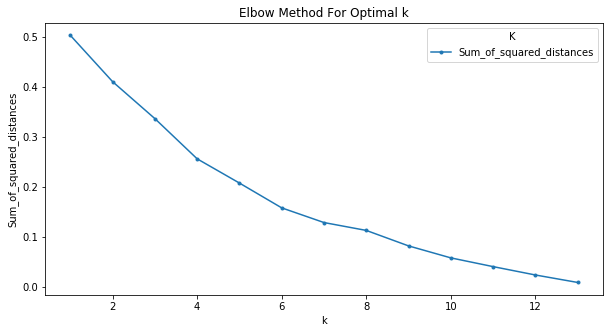

In [61]:
stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)

Sum_of_squared_distances = []
K = range(1, 14)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(stpaul_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_) 

# plot the K
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
optimal_k.plot(kind = 'line', figsize = (10, 5), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The best K value seems to be 6 for our datasets.  

Run the k-means into 6 clusters:

In [63]:
# set number of clusters
kclusters = 6

stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stpaul_grouped_clustering)

In [78]:
neighborhoods_venues_sorted['Zipcode']=neighborhoods_venues_sorted['Zipcode'].astype(int)
stpaul_merged['zipcode']=stpaul_merged['zipcode'].astype(int)

In [79]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

stpaul_merged = zipStPaul

# merge zipStPaul with neighborhoods_venues to add latitude/longitude for each neighborhood
stpaul_merged = stpaul_merged.join(neighborhoods_venues_sorted.set_index('Zipcode'), on='zipcode')

stpaul_merged.head() 

,zipcode,med_income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,44.95,-93.09,2,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,46255,44.93,-93.12,2,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
2,55103,28899,44.97,-93.13,1,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House
3,55104,44629,44.96,-93.17,2,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,76472,44.93,-93.16,2,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant


Visualizing the clusters:

In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stpaul_merged['latitude'], stpaul_merged['longitude'], stpaul_merged['zipcode'], stpaul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [83]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 0, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,55106,42686,Mexican Restaurant,Chinese Restaurant,Pizza Place,Park,Bar,Veterinarians,Pet Stores,Brewery,Fast Food Restaurant,Butcher
16,55117,44040,Veterinarians,Fast Food Restaurant,Gym / Fitness Center,American Restaurant,Grocery Store,Sandwich Place,Video Store,Chinese Restaurant,Bar,Dessert Shop
18,55119,56275,Fast Food Restaurant,Video Store,Pizza Place,Coffee Shop,Chinese Restaurant,Burger Joint,Veterinarians,Miscellaneous Shop,Mobile Phone Shop,Shoe Store


`Cluster 1` has Veterinarians as part of their top 10 most common categories. It can be categorized as a potential spot for a new pet store location. The median income is in the $40-50k, which is in the upper middle value in our zipcode dataset. 

#### Cluster 2

In [84]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 1, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,55103,28899,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House


``Cluster 2`` is located in 55103 zipcode, which can be categorized as the [North End](https://www.unitedstateszipcodes.org/55103) neighborhood. It does not seem to be a good place to open a new pet store, with low median income and no mention of pet categories in the top 10 most common venue.

#### Cluster 3

In [85]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 2, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,46255,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
3,55104,44629,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,76472,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant
7,55108,56994,Coffee Shop,Park,American Restaurant,Snack Place,Veterinarians,Event Space,Breakfast Spot,Café,Campground,Exhibit
12,55113,61113,Veterinarians,Chinese Restaurant,Pizza Place,Coffee Shop,Pet Stores,Sandwich Place,American Restaurant,Shoe Store,Pub,Music Store
15,55116,61142,Coffee Shop,American Restaurant,Park,Scenic Lookout,Veterinarians,Liquor Store,Mexican Restaurant,Trail,Pizza Place,Pet Stores


`Cluster 3` has Dog Walkers, Veterinarians, Pet Sitting, and Pet Stores as part of their top 10 most common categories. It is more promising than `Cluster 1` because of the higher median income as well.  

From the list, I can recommend opening up a new pet store from **55105** zip code, which is located in the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/). It has a high median income and there is no mention of pet store in the top 10 most common venues in the area. 

The second place that I would recommend is the **55108** zip code, which is located near the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/). It has a slightly lower median income, but there are already veterinarians as the top 10 most common venues in this neighborhood.

The third place that I would recommend is the **55104** zip code, which is located in the [Hamline-Midway neighborhood](https://www.unitedstateszipcodes.org/55104/). It has pet sitting as the most common venue, with a lower median income in the area. More research needs to be done if our client pick this area as their preferred location.

#### Cluster 4

In [100]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 3, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,55107,44913,Mexican Restaurant,Brewery,Pet Training,Restaurant,Harbor / Marina,Burrito Place,Taco Place,Automotive Shop,Scenic Lookout,Pet Groomers


``Cluster 4`` is located in 55107 zipcode, which can be categorized as the [West End](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with having both Pet Training and Pet Groomers already in the top 10 most common venue. Pet Groomers usually sell similar items that are the same as Pet Stores on top of their grooming business.

#### Cluster 5

In [87]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 4, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,55130,30092,Liquor Store,American Restaurant,Pet Sitting,History Museum,Gastropub,Dog Run,Pet Training,Athletics & Sports,Italian Restaurant,Restaurant


``Cluster 5`` is located in 55130 zipcode, which can be categorized as the [Payne-Phalen](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with low median income value and having Pet Sitting, Dog Run, and Pet Training already in the top 10 most common venue. They signal a saturated neighborhood to open a Pet Store.

#### Cluster 6

In [88]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 5, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,55114,38861,Coffee Shop,Brewery,Record Shop,Bar,Italian Restaurant,Gym,Middle Eastern Restaurant,Music Store,Organic Grocery,Pet Services


``Cluster 6`` is located in 55114 zipcode, which can be categorized as the [St. Anthony](https://www.unitedstateszipcodes.org/55114) neighborhood. It does not seem to be a good place to open a new pet store, with low median income value and having Pet Services already in the top 10 most common venue. They signal a neighborhood that might not be able to sustain a Pet Store in the area.

### Dig deeper into the Three Clusters

I picked: 55105, 55108, and 55104 as the three best zip codes to open a new pet store. Let's look at the data on what is available in the area. 

- 55105: [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/)

In [89]:
zipcode55105 = combined_df[combined_df['Venue Zipcode']==55105]
zipcode55105[zipcode55105['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
246,Bubbly Paws,55105,44.940280,-93.140160,Pet Groomers
248,Dog Days Daycare & Boarding - Grand Ave,55105,44.939774,-93.174835,Pet Training
249,Grand Avenue Veterinary Center,55105,44.939693,-93.148247,Veterinarians
250,Grand Groomers,55105,44.939659,-93.140472,Pet Groomers
251,St. Paul Pet Supply,55105,44.939978,-93.174938,Pet Stores
259,Animal Medical Clinic,55105,44.934563,-93.166825,Veterinarians


Check on the grocery and supermarket in the area:

In [90]:
zipcode55105[zipcode55105['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
200,Trader Joe's,55105,44.926666,-93.146004,Grocery Store
217,Kowalski's Market,55105,44.940270,-93.153639,Grocery Store


The competitors for this area is only St. Paul Pet Supply. However, as shown above, there are two grocery stores that do sell pet related items in their shelves. This area can be a very good location to open up a new pet store, ensuring that the type of items sold in the pet stores are different enough than the ones sold in grocery stores.

- 55108: [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/)

In [92]:
zipcode55108 = combined_df[combined_df['Venue Zipcode']==55108]
zipcode55108[zipcode55108['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
332,Raptor Center,55108,44.982871,-93.181639,Veterinarians
333,University of Minnesota Veterinary Medical Center,55108,44.982202,-93.181925,Veterinarians
338,Animal Humane Society - St. Paul,55108,44.974723,-93.154704,Animal Shelters


Check on the grocery and supermarket category:

In [93]:
zipcode55108[zipcode55108['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
310,Tim & Tom's Speedy Market,55108,44.981728,-93.195084,Grocery Store


We did not see any pet store in this zip code. Plus, the [Tim & Tom's Speedy Market](https://timandtomsspeedymarket.com/) is a specialty grocery store that do not sell pet related items. A close contender in terms of a good location to open up a new pet store.  

- 55104: [Hamline-Midway neighborhood](https://www.unitedstateszipcodes.org/55104/)

In [94]:
zipcode55104 = combined_df[combined_df['Venue Zipcode']==55104]
zipcode55104[zipcode55104['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
158,Urban Tails Waggin,55104,44.947160,-93.126560,Dog Walkers
159,St. Paws Dog Daycare & Boarding,55104,44.956924,-93.181053,Pet Sitting
160,Midway Animal Hospital,55104,44.963242,-93.167572,Veterinarians
184,Grand Paws Professional Dog & Cat Grooming,55104,44.959050,-93.156620,Pet Sitting
185,Feline Rescue,55104,44.959064,-93.177597,Animal Shelters
186,VCA Feist Animal Hospital,55104,44.948252,-93.160780,Pet Sitting
187,Pawsitivity Service Dogs,55104,44.947284,-93.151974,Pet Services


Check on the grocery and supermarket category:

In [101]:
zipcode55104[zipcode55104['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category


We did not see any pet store in this zip code, but there are two veterinarians hospitals, where they can potentially sell food and toys for their patients. I would proceed with caution in this location since it is also a lower income area. Plus side is that there is no grocery store in this area. 